In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


 Loading dataset...
 Cleaning dataset...
 Converting Date & Time...
 Splitting data into train and test sets...

 Training models...
Linear Regression: MSE = 0.0016, R² = 0.9986
Random Forest: MSE = 0.0011, R² = 0.9990
Gradient Boosting: MSE = 0.0012, R² = 0.9990

 Best Model: Random Forest with R² = 0.9990

 Plotting Actual vs Predicted values...


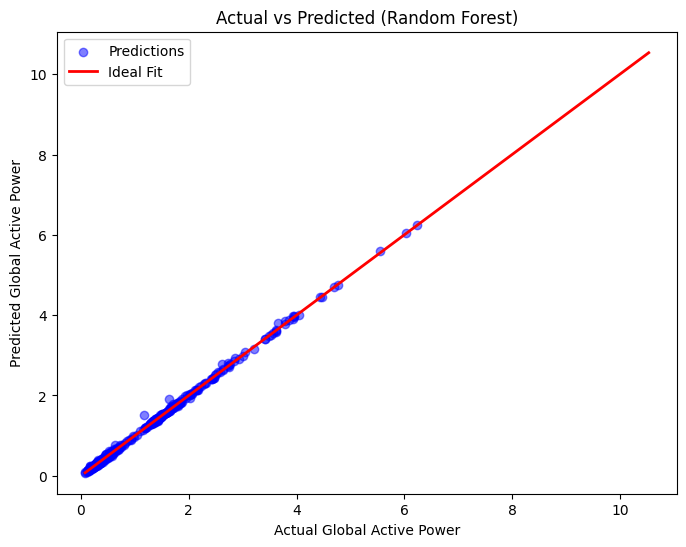


 Plotting Feature Importance...


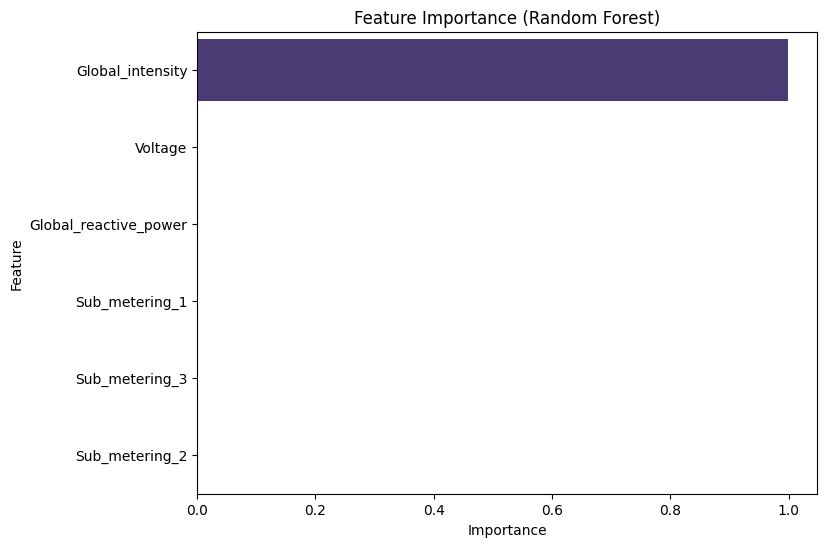


 Plotting Energy Consumption Trends...


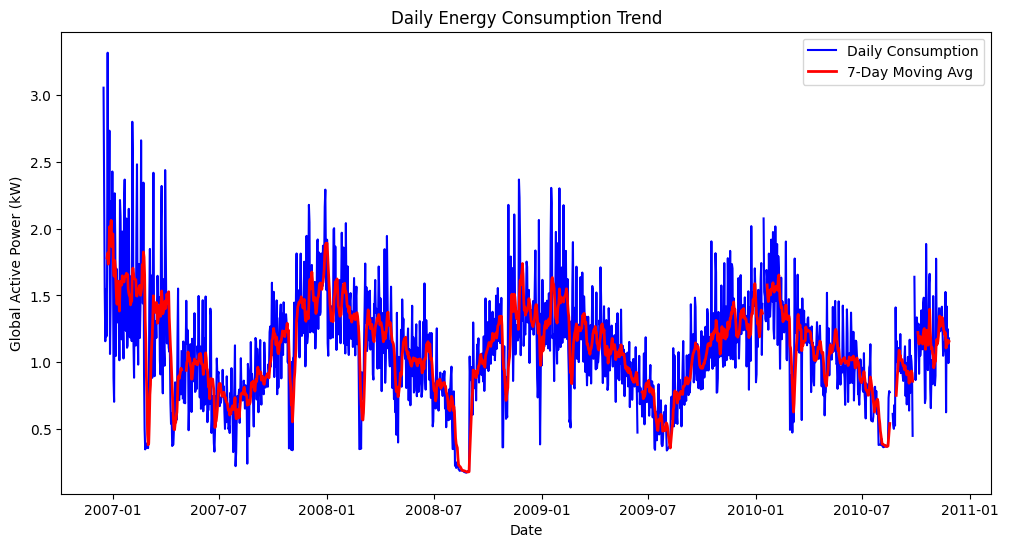

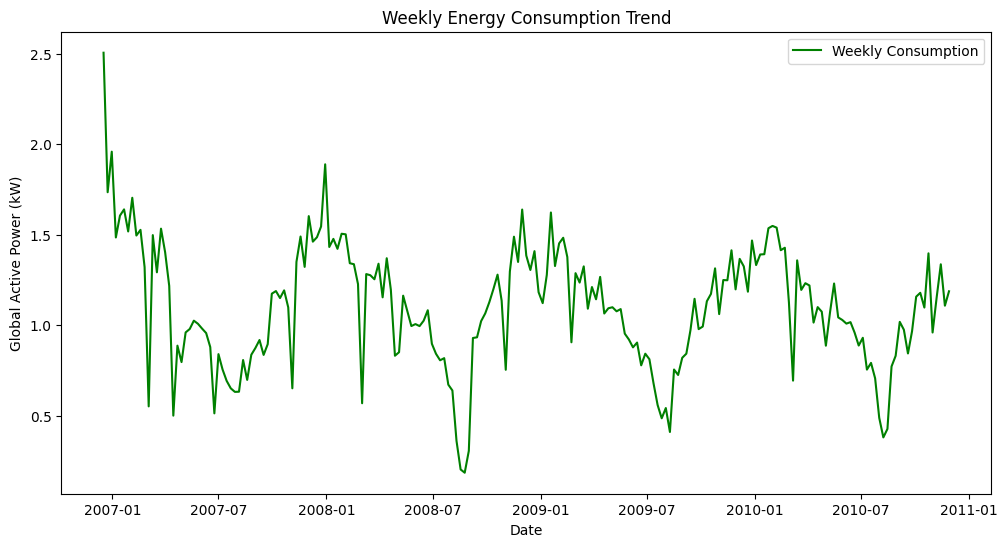

In [2]:
# Smart Energy Consumption Analyzer with Time-Series Visuals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load Dataset
file_path = "/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt"
print(" Loading dataset...")

data = pd.read_csv(file_path, sep=";", low_memory=False)

# 2. Clean Dataset
print(" Cleaning dataset...")
data.replace("?", np.nan, inplace=True)
data.dropna(inplace=True)

# Convert numeric columns
for col in data.columns[2:]:
    data[col] = pd.to_numeric(data[col])

# 3. Parse Date & Time
print(" Converting Date & Time...")
data["DateTime"] = pd.to_datetime(data["Date"] + " " + data["Time"], format="%d/%m/%Y %H:%M:%S")
data.set_index("DateTime", inplace=True)

# 4. Select Features & Target
features = ["Global_reactive_power", "Voltage", "Global_intensity", 
            "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]
target = "Global_active_power"

X = data[features]
y = data[target]

# 5. Train/Test Split
print(" Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Train Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

print("\n Training models...")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = (mse, r2)
    print(f"{name}: MSE = {mse:.4f}, R² = {r2:.4f}")

# 7. Select Best Model
best_model_name = max(results, key=lambda x: results[x][1])
best_model = models[best_model_name]
print(f"\n Best Model: {best_model_name} with R² = {results[best_model_name][1]:.4f}")

# 8. Visualization - Actual vs Predicted
print("\n Plotting Actual vs Predicted values...")
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test[:500], y_pred_best[:500], alpha=0.5, color="blue", label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color="red", linewidth=2, label="Ideal Fit")
plt.xlabel("Actual Global Active Power")
plt.ylabel("Predicted Global Active Power")
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.legend()
plt.show()

# 9. Feature Importance (only for tree models)
if best_model_name in ["Random Forest", "Gradient Boosting"]:
    print("\n Plotting Feature Importance...")
    importance = best_model.feature_importances_
    feature_importance = pd.DataFrame({"Feature": features, "Importance": importance})
    feature_importance.sort_values(by="Importance", ascending=False, inplace=True)

    plt.figure(figsize=(8,6))
    sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")
    plt.title(f"Feature Importance ({best_model_name})")
    plt.show()

# 10. Time-Series Analysis
print("\n Plotting Energy Consumption Trends...")

# Daily trend
daily_consumption = data[target].resample("D").mean()

plt.figure(figsize=(12,6))
plt.plot(daily_consumption, label="Daily Consumption", color="blue")
plt.plot(daily_consumption.rolling(7).mean(), label="7-Day Moving Avg", color="red", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.title("Daily Energy Consumption Trend")
plt.legend()
plt.show()

# Weekly trend
weekly_consumption = data[target].resample("W").mean()

plt.figure(figsize=(12,6))
plt.plot(weekly_consumption, label="Weekly Consumption", color="green")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.title("Weekly Energy Consumption Trend")
plt.legend()
plt.show()